This notebook covers the use of the library to perform feature selection in a regression problem. 

# Problem information


Friedman-1 regression (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html)
 
$$
y = 10 \sin(\pi x_1 x_2) + 20 (x_3 - 0.5)^2 + 10 x_4 + 5 x_5 + \epsilon
$$

In this problem we know that the true labels correspond to: "feat_1", "feat_2", "feat_3", "feat_4", and "feat_5". We know that the rest of the features are noise and therefore the feature selection should be able to identify these 5 variables.


The objective function optimized by means of genetic algorithms corresponds to the mean square error obtained by means of a Support Vector Machines model adapted to regression. 

__IMPORTANT INFORMATION__

- The problem has been planted as a minimization.
- The internal model has not been evaluated by cross-validation.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# used libraries
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

import pywinEA2

In [2]:
# --- BASIC GENETIC ALGORITHM PARAMETERS
# --------------------------------------

# Population size of the genetic algorithm
POPULATION_SIZE = 100

# Maximum number of algorithm iterations
MAX_GENERATIONS = 100

# Optimized score and direction
# 
# The optimized score can be provided as a string (to see the scores already implemented use):
#
#     $ list(pywinEA2.fitness.FeatureSelectionFitness.VALID_SCORES.keys())
#
# Or it can also be specified as a callable that receives some parameters from 'y_pred' and 
# 'y_true' and returns a scalar value. For example:
#
#     $ from sklearn.metrics import f1_score
#     $
#     $  OPTIM_SCORE = f1_score
#
#
OPTIM_SCORE = 'mean_squared_error'
OPTIM = 'min'

# Parameters related to the mutation process
MUTATION_OP = 'bit_flip'         # mutation operator (default parameter 'bit_flip')
PROB_MUTATION = 0.25             # probability of an individual being selected for mutation
MUTATION_KWARGS = dict(          # optional mutation operator parameters
    indpb=0.05                   # probability that a position in the chromosome mutates (default parameter 0.05)
)

# Parameters related to the cross-over process
CROSSOVER_OP = 'one_point'       # cross-over operator (default setting 'one_point')
PROB_CROSSOVER = 0.75            # probability that an individual will be selected for cross-over


# Parameters related to the individual selection process
SELECTION_OP = 'tournament'     # selection operator (default parameter 'tournament')
SELECTION_KWARGS = dict(        # optional selection operator parameters
    tournsize=2                 # number of individuals selected for the tournament (default parameter 2)
)


# --- PARAMETERS USED TO GENERATE THE TEST DATASET
# ------------------------------------------------
N_SAMPLES = 200
N_FEATURES = 90
NOISE = 0.5

# misc
SEED = 1997

In [3]:
def getDataset() -> pd.DataFrame:
    """ Create the testing dataset """
    X, y = datasets.make_friedman1(
        n_samples=N_SAMPLES,
        n_features=N_FEATURES,
        noise=NOISE,
        random_state=SEED)
    
    X = pd.DataFrame(X, columns=['feat_{}'.format(f+1) for f in range(X.shape[1])])
    y = pd.DataFrame(y, columns=['target'])
    data = pd.concat([X, y], axis=1)
    
    return data

In [4]:
data = getDataset()
data.head(5)

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,target
0,0.771148,0.074757,0.526310,0.975088,0.992226,0.465135,0.611135,0.569463,0.667719,0.786780,...,0.739056,0.189999,0.354658,0.213068,0.424554,0.320884,0.967451,0.063337,0.225850,16.864643
1,0.944677,0.166228,0.077853,0.717844,0.920020,0.615669,0.299287,0.847137,0.508283,0.131813,...,0.266088,0.491251,0.377104,0.265917,0.857921,0.914392,0.771561,0.187760,0.384997,20.389099
2,0.217790,0.972564,0.403189,0.872092,0.682622,0.445948,0.288469,0.761892,0.621428,0.208704,...,0.212825,0.341531,0.144842,0.435395,0.022645,0.667047,0.036734,0.655309,0.418235,18.261778
3,0.422399,0.438913,0.771213,0.502754,0.824081,0.200905,0.374775,0.723844,0.835281,0.951988,...,0.629061,0.112162,0.667163,0.303717,0.528023,0.122898,0.449646,0.511640,0.581908,15.298821
4,0.341653,0.076352,0.535166,0.679331,0.747861,0.665039,0.877723,0.025591,0.277263,0.648561,...,0.053892,0.553951,0.727013,0.407122,0.062515,0.518457,0.470395,0.892971,0.454677,11.989297


## Baseline model
Evaluation of the MSE obtained by a baseline model (without applying cross-validation) using all the features

In [5]:
model = SVR() 
baseline_model = model.fit(data[data.columns.tolist()[:-1]], data['target'])
y_pred = baseline_model.predict(data[data.columns.tolist()[:-1]])
baseline_mse = np.mean((y_pred - data['target'].values)**2)
print('Baseline MSE: {:.3f}'.format(baseline_mse))

Baseline MSE: 17.351


## Basic genetic algorithm

For a more direct application of the different algorithms, the pywinEA2 library incorporates two wrapper classes applicable to different types of algorithms. The most basic is __pywinEA2.FeatureSelectionGA__ which allows the execution of single-objective genetic algorithms.

In [6]:
help(pywinEA2.FeatureSelectionGA)   # to access documentation

Help on class FeatureSelectionGA in module pywinEA2.wrapper:

class FeatureSelectionGA(pywinEA2.base.BaseWrapper)
 |  FeatureSelectionGA(data: pandas.core.frame.DataFrame, model: sklearn.base.BaseEstimator, score: str, y: list, population_size: int, max_generations: int, optim: str, objective_kw: dict = None, p_crossover: float = 0.5, crossover_op: str = 'one_point', crossover_kw: dict = None, p_mutation: float = 0.2, mutation_op: str = 'bit_flip', mutation_kw: dict = None, selection_op: str = 'tournament', selection_kw: dict = None, fixed_feats: list = None, target_feats: list = None, cv: int = None, cv_reps: int = None, stratified: bool = False, random_seed: int = None, n_jobs: int = 1)
 |  
 |  Class implementing a genetic algorithm for feature selection.
 |  
 |  Parameters
 |  ----------
 |  :param data: pd.DataFrame
 |  :param model: sklearn.base.BaseEstimator
 |  :score: str
 |      Scoring function to be optimized.
 |  :param y: list
 |      Dependent variable (regression tasks

In [7]:
ga_wrapper = pywinEA2.FeatureSelectionGA(
    # data-related parameters
    data=data,
    model=SVR(),
    score=OPTIM_SCORE,
    y=['target'],                       # target variable (must be present in the data)
    population_size=POPULATION_SIZE,
    max_generations=MAX_GENERATIONS,
    optim=OPTIM,
    # ... indicate here if there is any variable that will not be subjected to the feature 
    # selection process but should be passed to the model. By default all variables will be 
    # subject to feature selection.
    fixed_feats=None,
    # ... subject all variables except the 'target' variable to the feture selection
    target_feats=data.columns.tolist()[:-1],  
    
    # genetic algorithm operators
    mutation_op=MUTATION_OP,
    p_mutation=PROB_MUTATION,
    mutation_kw=MUTATION_KWARGS,
    
    crossover_op=CROSSOVER_OP,
    p_crossover=PROB_CROSSOVER,
    crossover_kw=None,
    
    selection_op=SELECTION_OP,
    selection_kw=SELECTION_KWARGS,
    
    # cross-validation parameters  (in this particular case, cross validation will not be applied to the objective function)
    cv= None,
    cv_reps= None,
    stratified=False,
)

Once the problem wrapper has been defined, just run the algorithm and a report will be returned. Currently, for single-objective genetic algorithms the following variants are implemented:

- 'eaSimple'
- 'eaMuPlusLambda'
- 'eaMuCommaLambda'
- 'eaSimpleWithElitism'
- 'eaMuCommaLambdaWithElitism'

In [8]:
ga_1_report = pywinEA2.run(ga_wrapper, type='eaSimple', verbose=True)

gen	nevals	avg   	std    	min    	max    	sum   
0  	100   	17.917	1.68807	14.5164	21.5826	1791.7
1  	86    	16.9523	1.37613	13.9573	19.9236	1695.23
2  	85    	16.3567	1.12087	14.0243	19.4302	1635.67
3  	89    	15.8281	0.956451	14.1835	19.1465	1582.81
4  	77    	15.3546	0.777414	13.7355	17.0535	1535.46
5  	89    	15.0412	0.769501	13.3792	17.4694	1504.12
6  	92    	14.7639	0.863616	13.4224	18.1202	1476.39
7  	81    	14.4174	0.613922	12.6453	16.5697	1441.74
8  	68    	14.0575	0.5473  	12.488 	16.1964	1405.75
9  	74    	13.8234	0.66475 	12.488 	16.2778	1382.34
10 	85    	13.5991	0.576365	12.4049	16.3348	1359.91
11 	81    	13.4004	0.64994 	12.5122	16.5934	1340.04
12 	80    	13.2717	0.725152	12.1573	17.2411	1327.17
13 	77    	13.0372	0.473293	12.3486	15.956 	1303.72
14 	85    	12.9409	0.449618	11.9039	14.714 	1294.09
15 	81    	12.8963	0.632477	11.9262	15.9443	1289.63
16 	80    	12.6853	0.573742	11.5549	15.7483	1268.53
17 	81    	12.608 	0.666899	10.8605	16.273 	1260.8 
18 	88    	12.4796	0

The following are some of the utilities implemented in the generated report:

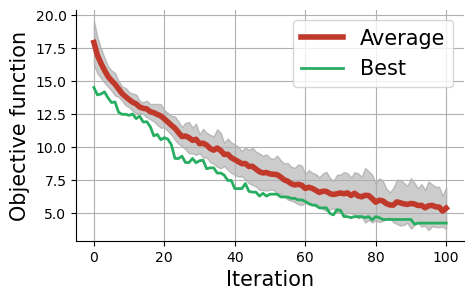

In [9]:
# display model convergence
pywinEA2.report.displayConvergence(
    ga_1_report,
    figsize=(5, 3),
)

In [10]:
# access the population (the population from the last iteration) 
population = ga_1_report.population 
type(population), len(population), len(population[0])

(list, 100, 90)

In [11]:
# e.g. let's see the percentage of times each feature is present in the population
np.array(population).mean(axis=0) * 100

array([ 98., 100.,   2.,  98., 100.,   0.,  44.,   3.,   0.,   5.,   0.,
         3.,   1.,   5.,   2.,   5.,   0.,   2.,  21.,   1.,   0.,   7.,
         1.,   2.,   7.,   3.,   2.,   1.,   3.,   1.,   0.,   0.,   3.,
         1.,   4.,   2.,   4.,   1.,   0.,  96.,   1.,   3.,   1.,   3.,
         1.,   2.,   0.,   0.,   0.,   1.,   5.,   1.,   1.,   9.,   2.,
         2.,   8.,   2.,   0.,   1.,   5.,   1.,   7.,   3.,   5.,   1.,
         0.,   4.,   5.,   2.,   4.,   0.,   1.,   0.,   1.,   0.,  93.,
         9.,   1.,   5.,   1.,   1.,   1.,   2.,   1.,   2.,   1.,   0.,
         0.,   1.])

The best solution can be accessed by the __hall_of_fame__ method (Hall Of Fame)

In [12]:
len(ga_1_report.hall_of_fame)

1

In this case, the 5 characteristics that should be selected have been selected and in addition an extra noise characteristic has been added.

In [13]:
in_features = data.columns[:-1]
selected_feats = list(in_features[np.array(ga_1_report.hall_of_fame[0], dtype=bool)])
selected_feats

['feat_1',
 'feat_2',
 'feat_3',
 'feat_4',
 'feat_5',
 'feat_7',
 'feat_40',
 'feat_77']

It can be seen below that the model error has dropped considerably with respect to the error obtained using all the features.

In [14]:
model = SVR() 
new_model = model.fit(data[selected_feats], data['target'])
y_pred = new_model.predict(data[selected_feats])
new_mse = np.mean((y_pred - data['target'].values)**2)
print('Baseline MSE: {:.3f}'.format(new_mse))

Baseline MSE: 4.182


The same wrapper can be used to execute other algorithms. For example, let's add an elitism strategy to the version of the previously executed algorithm.

**With the parameter hof_size (Hall Of Fame) we can specify that the 10 best individuals of the population pass directly to the next generation.** This should accelerate convergence with the side effect of increasing the probability of reaching a local optimum (exploration/exploitation balance).

In [15]:
# The same wrapper can be used to execute other algorithms
ga_2_report = pywinEA2.run(ga_wrapper, type='eaSimpleWithElitism', hof_size=10, verbose=True)

gen	nevals	avg    	std    	min    	max    	sum    
0  	100   	17.9757	1.42764	14.0436	21.3352	1797.57
1  	74    	17.1974	1.32915	14.0436	20.2918	1719.74
2  	63    	16.2579	1.27376	13.7487	18.9716	1625.79
3  	72    	15.5273	1.13371	12.9623	18.4801	1552.73
4  	62    	14.8137	0.922344	12.9623	18.6692	1481.37
5  	76    	14.3965	0.743922	12.9623	16.4144	1439.65
6  	71    	14.1151	0.714142	12.8467	16.9717	1411.51
7  	72    	13.7289	0.60915 	11.9362	16.6099	1372.89
8  	69    	13.3812	0.621895	11.7535	15.8068	1338.12
9  	70    	13.0729	0.710328	11.7535	16.4835	1307.29
10 	67    	12.7115	0.688485	11.4195	14.6691	1271.15
11 	74    	12.4757	0.918506	11.3348	18.0496	1247.57
12 	79    	12.2722	1.06148 	10.7494	15.9986	1227.22
13 	75    	11.9209	0.752873	10.6204	14.8954	1192.09
14 	68    	11.6344	0.978649	10.4554	17.4575	1163.44
15 	70    	11.4164	1.08089 	9.80916	17.3859	1141.64
16 	72    	11.0325	0.708292	9.59639	14.3094	1103.25
17 	77    	10.7572	0.542686	9.59639	12.13  	1075.72
18 	62    	10.637

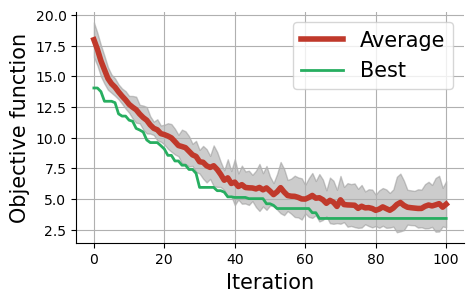

In [16]:
# display model convergence
pywinEA2.report.displayConvergence(
    ga_2_report,
    figsize=(5, 3),
)

Let's run one more variant of the single-objective algorithms and compare convergence. In this case let's make the output not so verbose.

In [17]:
# The same wrapper can be used to execute other algorithms
ga_3_report = pywinEA2.run(ga_wrapper, type='eaMuCommaLambda', verbose=False)
ga_4_report = pywinEA2.run(ga_wrapper, type='eaMuCommaLambdaWithElitism', hof_size=20, verbose=False)

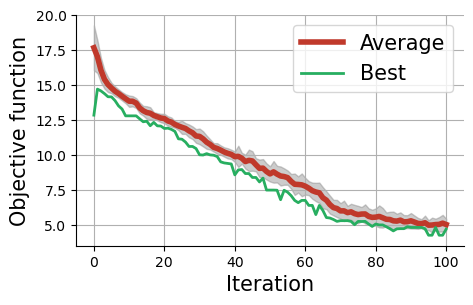

In [18]:
# display model convergence
pywinEA2.report.displayConvergence(
    ga_3_report,
    figsize=(5, 3),
)

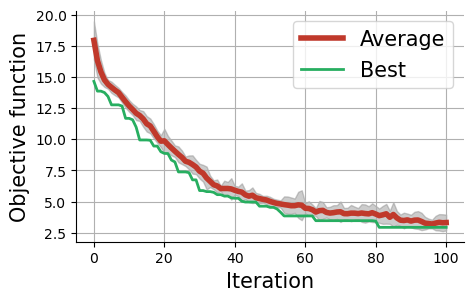

In [19]:
# display model convergence
pywinEA2.report.displayConvergence(
    ga_4_report,
    figsize=(5, 3),
)

Through the __get__ method of the report it is possible to access the convergence history (for more information see __report.TRACKING_METRICS__).

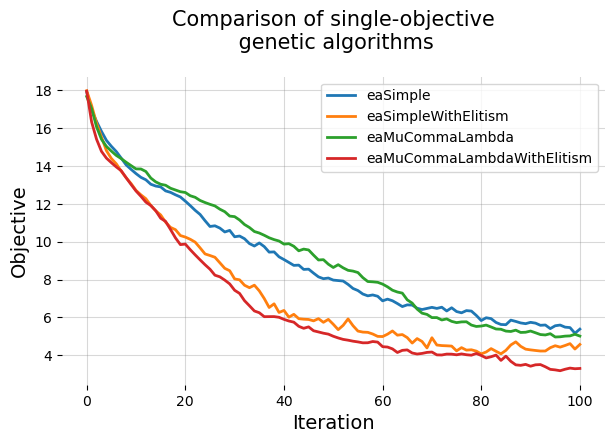

In [20]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(
    ga_1_report.get('avg'),
    label='eaSimple',
    lw=2
)
ax.plot(
    ga_2_report.get('avg'),
    label='eaSimpleWithElitism',
    lw=2
)

ax.plot(
    ga_3_report.get('avg'),
    label='eaMuCommaLambda',
    lw=2
)
ax.plot(
    ga_4_report.get('avg'),
    label='eaMuCommaLambdaWithElitism',
    lw=2
)

for pos in ['top', 'right', 'left', 'bottom']:
    ax.spines[pos].set_visible(False)
    
ax.grid(alpha=0.3, color='grey')
ax.set_xlabel('Iteration', size=14)
ax.set_ylabel('Objective', size=14)
ax.legend()
ax.set_title('Comparison of single-objective\n genetic algorithms', size=15, pad=20)
plt.show()

# Multi-objective genetic algorithm

The other wrapper that can be used to run genetic algorithms "hands off" is __pywinEA2.MultiObjFeatureSelectionNSGA2__ (although the framework offers enough flexibility to run genetic algorithms to problems beyond feature selection).

In this case, this wrapper can be used to run a multi-objective genetic algorithm where one objective will be to minimize the score (as before), and the other extra objective (transparent to the user) will be to minimize the number of input features.

In this case the same parameters are used as for the mono-objetive algorithms (__Warnings can be safely ignored__)

In [21]:
# create the genetic algorithm instance (same parameters than as before)
nsga2_wrapper = pywinEA2.MultiObjFeatureSelectionNSGA2(
    # data-related parameters
    data=data,
    model=SVR(),
    score=OPTIM_SCORE,
    y=['target'],                       # target variable (must be present in the data)
    population_size=POPULATION_SIZE,
    max_generations=MAX_GENERATIONS,
    optim=OPTIM,
    # ... indicate here if there is any variable that will not be subjected to the feature 
    # selection process but should be passed to the model. By default all variables will be 
    # subject to feature selection.
    fixed_feats=None,
    # ... subject all variables except the 'target' variable to the feture selection
    target_feats=data.columns.tolist()[:-1],  
    
    # genetic algorithm operators
    mutation_op=MUTATION_OP,
    p_mutation=PROB_MUTATION,
    mutation_kw=MUTATION_KWARGS,
    
    crossover_op=CROSSOVER_OP,
    p_crossover=PROB_CROSSOVER,
    crossover_kw=None,
    
    selection_op=SELECTION_OP,
    selection_kw=SELECTION_KWARGS,
    
    # cross-validation parameters  (in this particular case, cross validation will not be applied to the objective function)
    cv= None,
    cv_reps= None,
    stratified=False,
)

/home/fgarcia/anaconda3/envs/mlv0/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/fgarcia/anaconda3/envs/mlv0/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [22]:
# The latest version of deap (base library of genetic algorithms used to build pywinEA2) throws a very annoying warning when calculating the 
# hypervolume. Silence it
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    nsga2_report = pywinEA2.run(nsga2_wrapper, type='nsga2', verbose=True)

gen	nevals	avg    	std    	min    	max	sum    	multiobj_fitness_values_mean	multiobj_fitness_values_min	multiobj_fitness_values_max
0  	      	31.3778	13.8629	14.7549	57 	6275.56	[17.97555334 44.78      ]   	[14.75489687 35.        ]  	[20.83244158 57.        ]  
1  	      	29.549 	13.2292	14.0274	54 	5909.8 	[16.78803973 42.31      ]   	[14.02740037 32.        ]  	[20.83244158 54.        ]  
2  	      	27.8719	12.0201	14.0274	49 	5574.39	[16.26388542 39.48      ]   	[14.02740037 30.        ]  	[20.73267818 49.        ]  
3  	      	26.3278	10.87  	13.8302	48 	5265.56	[15.79561634 36.86      ]   	[13.83021263 30.        ]  	[20.4142436 48.       ]    
4  	      	25.2705	10.0511	13.6374	43 	5054.1 	[15.53095074 35.01      ]   	[13.63739807 29.        ]  	[20.22790761 43.        ]  
5  	      	24.5093	10.0017	13.3084	42 	4901.86	[14.8286288 34.19     ]     	[13.30835945 29.        ]  	[20.01613675 42.        ]  
6  	      	23.6085	9.14056	12.4436	40 	4721.71	[14.77707456 32.44      ]   	

As before, the report generated gathers very relevant information. In this case it includes methods adapted for multi-objective genetic algorithms.

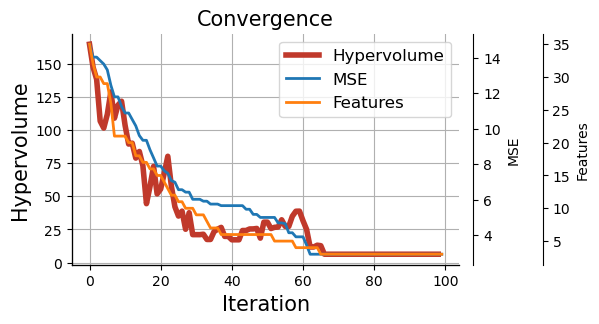

In [23]:
pywinEA2.report.displayMultiObjectiveConvergence(
    nsga2_report,
    title='Convergence', 
    objective_names=['MSE', 'Features'],
    figsize=(5, 3),
    title_size=15,
    legend_size=12
)

In the case of multi-objective algorithms, a non-dominated solution front is obtained.

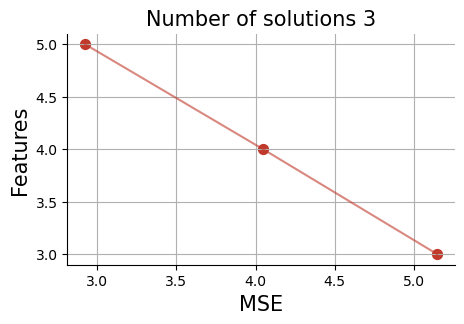

In [24]:
pywinEA2.report.displayParetoFront(
    nsga2_report,
    objective_names=['Features', 'MSE'],
    figsize=(5, 3),
    title_size=15
)

The solutions of the pareto front can be accessed using the pareto_front method

In [25]:
np.array(list(nsga2_report.pareto_front)).shape

(3, 90)

Let's look at the two solutions on the non-dominated solution front

In [26]:
in_features = data.columns.values[:-1]

for i in range(len(nsga2_report.pareto_front)):
    print('Solution %d: %r' % (i, in_features[np.array(nsga2_report.pareto_front[i], dtype=bool)]))

Solution 0: array(['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5'], dtype=object)
Solution 1: array(['feat_1', 'feat_2', 'feat_4', 'feat_5'], dtype=object)
Solution 2: array(['feat_1', 'feat_2', 'feat_4'], dtype=object)
